# Predicting house prices using k-nearest neighbors regression
In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [1]:
# Fire up pandas, scikitlearn and numpy
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

# Load in house sales data

For this notebook, we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
sales = pd.read_csv('kc_house_data_small.csv')

# Import useful functions from previous notebooks

To efficiently compute pairwise distances among data points, we will convert the SFrame into a 2D Numpy array. First import the numpy library and then copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
def get_numpy_data(df, features, output):
    df['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of DataFrame given by the features list into the DataFrame features_df (now including constant):
    features_df = df[features]
    #print(df[features])
    # the following line will convert the features_df into a numpy matrix:
    feature_matrix = features_df.values
    # assign the column of data frame associated with the output to the SArray output_sarray
    output_sarray = df[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.values
    return(feature_matrix, output_array)

We will also need the `normalize_features()` function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [4]:
def normalize_features(features):
    #calculate norms
    norms = np.linalg.norm(features, axis=0)
    #calculate normalized features
    normalized_features = features/norms
    return (normalized_features, norms)

# Split data into training, test, and validation sets

In [5]:
train = pd.read_csv('kc_house_data_small_train.csv')
test = pd.read_csv('kc_house_data_small_test.csv')
validation = pd.read_csv('kc_house_data_validation.csv')

# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation dataFrames into Numpy arrays:

In [6]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
(features_train, output_train) = get_numpy_data(train, feature_list, 'price')
(features_test, output_test) = get_numpy_data(test, feature_list, 'price')
(features_valid, output_valid) = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [7]:
features_train, norms = normalize_features(features_train)
features_test = features_test / norms
features_valid = features_valid / norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1. Similarly, print the 10th row (index 9) of the training feature matrix.

In [9]:
print (features_test[0])
print (features_train[9])

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345387 -0.01346922  0.01375926  0.0016225 ]
[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346251  0.01195898  0.00156612]


***QUIZ QUESTION ***

What is the Euclidean distance between the query house and the 10th house of the training set? 

Note: Do not use the `np.linalg.norm` function; use `np.sqrt`, `np.sum`, and the power operator (`**`) instead. The latter approach is more easily adapted to computing multiple distances at once.

In [14]:
distance = np.sqrt(np.sum((features_train[9]-features_test[0])**2))

In [16]:
print('Answer: distance is', distance)

Answer: distance is 0.059723593714


# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [19]:
distance_testing = []
for i in range(0,10):
    distance = np.sqrt(np.sum((features_train[i]-features_test[0])**2))
    distance_testing.append(distance)
print(distance_testing)

[0.060274709162955922, 0.085468811476437465, 0.061499464352793153, 0.053402739792943632, 0.05844484060170442, 0.059879215098128345, 0.054631404967754607, 0.055431083236146074, 0.052383627840220305, 0.059723593713980783]


*** QUIZ QUESTION ***

Among the first 10 training houses, which house is the closest to the query house?

In [20]:
min(distance_testing)

0.052383627840220305

Answer: the 9th house and the index is 8

It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

Consider the following loop that computes the element-wise difference between the features of the query house (`features_test[0]`) and the first 3 training houses (`features_train[0:3]`):

In [42]:
for i in range(3):
    
    print (features_train[i]-features_test[0])
    # should print 3 vectors of length 18

[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -1.05552733e-02
   2.08673616e-04  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
   0.00000000e+00  -3.47633726e-03  -5.50336860e-03  -2.48168183e-02
  -1.63756198e-04   0.00000000e+00  -1.70254220e-05   1.29876855e-05
  -5.14364795e-03   6.69281453e-04]
[  0.00000000e+00  -3.87821276e-03  -4.51868214e-03  -2.26610387e-03
   7.19763456e-04   0.00000000e+00   0.00000000e+00  -5.10236549e-02
   0.00000000e+00  -3.47633726e-03   1.30705004e-03  -1.45830788e-02
  -1.91048898e-04   6.65082271e-02   4.23090220e-05   6.16364736e-06
  -2.89330197e-03   1.47606982e-03]
[  0.00000000e+00  -7.75642553e-03  -1.20498190e-02  -1.30002801e-02
   1.60518166e-03  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
   0.00000000e+00  -5.21450589e-03  -8.32384500e-03  -2.48168183e-02
  -3.13866046e-04   0.00000000e+00   4.70885840e-05   1.56292487e-05
   3.72914476e-03   1.64764925e-03]


The subtraction operator (`-`) in Numpy is vectorized as follows:

In [22]:
print (features_train[0:3] - features_test[0])

[[  0.00000000e+00  -3.87821276e-03  -1.20498190e-02  -1.05552733e-02
    2.08673616e-04  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03  -5.50336860e-03  -2.48168183e-02
   -1.63756198e-04   0.00000000e+00  -1.70254220e-05   1.29876855e-05
   -5.14364795e-03   6.69281453e-04]
 [  0.00000000e+00  -3.87821276e-03  -4.51868214e-03  -2.26610387e-03
    7.19763456e-04   0.00000000e+00   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -3.47633726e-03   1.30705004e-03  -1.45830788e-02
   -1.91048898e-04   6.65082271e-02   4.23090220e-05   6.16364736e-06
   -2.89330197e-03   1.47606982e-03]
 [  0.00000000e+00  -7.75642553e-03  -1.20498190e-02  -1.30002801e-02
    1.60518166e-03  -8.52950206e-03   0.00000000e+00  -5.10236549e-02
    0.00000000e+00  -5.21450589e-03  -8.32384500e-03  -2.48168183e-02
   -3.13866046e-04   0.00000000e+00   4.70885840e-05   1.56292487e-05
    3.72914476e-03   1.64764925e-03]]


Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [24]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print (results[0] - (features_train[0]-features_test[0]))
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print (results[1] - (features_train[1]-features_test[0]))
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print (results[2] - (features_train[2]-features_test[0]))
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [39]:
results[-1]

array([  0.00000000e+00,  -7.75642553e-03,  -1.20498190e-02,
        -1.30002801e-02,   1.60518166e-03,  -8.52950206e-03,
         0.00000000e+00,  -5.10236549e-02,   0.00000000e+00,
        -5.21450589e-03,  -8.32384500e-03,  -2.48168183e-02,
        -3.13866046e-04,   0.00000000e+00,   4.70885840e-05,
         1.56292487e-05,   3.72914476e-03,   1.64764925e-03])

Aside: it is a good idea to write tests like this cell whenever you are vectorizing a complicated operation.

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house.

In [70]:
diff = features_train - features_test[0]

In [71]:
diff

array([[  0.00000000e+00,  -3.87821276e-03,  -1.20498190e-02, ...,
          1.29876855e-05,  -5.14364795e-03,   6.69281453e-04],
       [  0.00000000e+00,  -3.87821276e-03,  -4.51868214e-03, ...,
          6.16364736e-06,  -2.89330197e-03,   1.47606982e-03],
       [  0.00000000e+00,  -7.75642553e-03,  -1.20498190e-02, ...,
          1.56292487e-05,   3.72914476e-03,   1.64764925e-03],
       ..., 
       [  0.00000000e+00,  -3.87821276e-03,  -3.01245476e-03, ...,
          5.43721749e-05,   8.35842791e-04,   7.02137088e-04],
       [  0.00000000e+00,   0.00000000e+00,  -3.01245476e-03, ...,
          2.28935473e-05,   2.44323277e-03,   8.20579624e-04],
       [  0.00000000e+00,  -3.87821276e-03,  -3.01245476e-03, ...,
          3.19188881e-06,  -3.92203156e-03,  -1.01041218e-03]])

To test the code above, run the following cell, which should output a value -0.0934339605842:

In [73]:
print (diff[-1].sum()) # sum of the feature differences between the query and last training house
# should print -0.0934339605842

-0.0934339987465


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [74]:
print (np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print (np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.00330705902846
0.00330705902846


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

**Hint**: Do not forget to take the square root of the sum of squares.

In [83]:
distances = np.sqrt(np.sum(diff**2, axis=1))

To test the code above, run the following cell, which should output a value 0.0237082324496:

In [84]:
print(distances[100]) # Euclidean distance between the query house and the 101th training house
# should print 0.0237082324496

0.0237082324167


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [85]:
def compute_distances(features_instances, features_query):
    diff = features_instances - features_query
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

*** QUIZ QUESTIONS ***

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [91]:
distances22 = compute_distances(features_train, features_test[2])
distances22

array([ 0.01954476,  0.06861035,  0.02165079, ...,  0.02433478,
        0.02622734,  0.02637942])

In [99]:
# approach 1:
print (min(distances22))

0.00286049555751


In [98]:
i, = np.where(distances22 == 0.0028604955575117085)
i

array([382])

In [101]:
# approach 2:
index_min = np.argmin(distances22)
print('Answer: the index of the index of the house in the training set that is closest to this query house:', index_min)

Answer: the index of the index of the house in the training set that is closest to this query house: 382


In [104]:
print('Answer:the predicted value of the query house based on 1-nearest neighbor regression is', output_train[382])

Answer:the predicted value of the query house based on 1-nearest neighbor regression is 249000


# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [113]:
def k_nearest_neighbors(k, feature_train, features_query):
    #calculate distances
    distances = compute_distances(feature_train, features_query)
    #find the indicies of houses with the shortest distances
    neighbors = np.argsort(distances)[0:k]
    return neighbors

*** QUIZ QUESTION ***

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

In [114]:
print('Answer:', k_nearest_neighbors(4, features_train, features_test[2]))

Answer: [ 382 1149 4087 3142]


## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [127]:
def predict_output_of_query(k, features_train, output_train, features_query):
    #find the k neighbors
    k_neighbors = k_nearest_neighbors(k, features_train, features_query)
    #make a prediction
    prediction = np.sum(output_train[k_neighbors])/k
    return prediction

*** QUIZ QUESTION ***

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [128]:
prediction_k4 = predict_output_of_query(4, features_train, output_train, features_test[2])

In [129]:
print('Answer:',prediction_k4)

Answer: 413987.5


Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [204]:
def predict_output(k, features_train, output_train, features_query):
    predictions=[]
    for i in range(0,features_query.shape[0]):
        prediction_i = predict_output_of_query(k, features_train, output_train, features_query[i])
        #print(prediction_i)
        predictions.append(prediction_i)
    #print(predictions)
    return predictions

*** QUIZ QUESTION ***

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. 

1. What is the index of the house in this query set that has the lowest predicted value? 
2. What is the predicted value of this house?

In [205]:
predictions_k10 = predict_output(10, features_train, output_train, features_test)
predictions_k10_10 = predictions_k10[0:10]
predictions_k10_10

[881300.0,
 431860.0,
 460595.0,
 430200.0,
 766750.0,
 667420.0,
 350032.0,
 512800.70000000001,
 484000.0,
 457235.0]

In [207]:
predictions_k10_10_np = np.array(predictions_k10_10)
index_min_k10_10_np = np.argmin(predictions_k10_10_np)
print('Answer:the index of the house in this query set that has the lowest predicted value is',index_min_k10_10_np)

Answer:the index of the house in this query set that has the lowest predicted value is 6


In [208]:
print('Answer: the predicted value of this house:',min(predictions_k10_10_np))

Answer: the predicted value of this house: 350032.0


## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

(Depending on your computing environment, this computation may take 10-15 minutes.)

In [212]:
rss_all = []
k_all =[]
for k in range(1,16):
    k_all.append(k)
    #make predictions for each house in the validation set
    predictions = predict_output(k, features_train, output_train, features_valid)
    #computes the RSS for these predictions on the VALIDATION set
    RSS = np.sum((predictions-output_valid)**2)
    rss_all.append(RSS)  
print(rss_all)
print(k_all)


[105453830251561.0, 83445073504025.5, 72692096019202.562, 71946721652091.688, 69846517419718.602, 68899544353180.836, 68341973450051.094, 67361678735491.5, 68372727958976.094, 69335048668556.742, 69523855215598.828, 69049969587246.172, 70011254508263.688, 70908698869034.344, 71106928385945.156]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [214]:
rss_all_np = np.array(rss_all)
index_min_rss_all_np = np.argmin(rss_all_np) 
index_min_rss_all_np

7

In [217]:
print('Answer: k produced the lowest RSS on VALIDATION set is',index_min_rss_all_np+1)

Answer: k produced the lowest RSS on VALIDATION set is 8


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

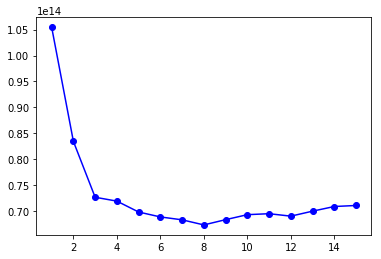

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

***QUIZ QUESTION ***

What is the RSS on the TEST data using the value of k found above?  To be clear, sum over all houses in the TEST set.

In [221]:
#make predictions for each house in the test set
predictions = predict_output(8, features_train, output_train, features_test)
#computes the RSS for these predictions on the test set
RSS = np.sum((predictions-output_test)**2)
print('Answer:',RSS)

Answer: 1.33118823552e+14
